In [1]:
import json
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
def parse_data(data_path):
    for l in open(data_path, 'r'):
        yield json.loads(l)

In [3]:
data_path = '/Users/gveni/Documents/data/nlp_data/Sarcasm_Headlines_Dataset.json'

# load data and parse
datastore = list(parse_data(data_path))

In [4]:
#  convert parsed data into a list of sentences
sentences = []
labels = []
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

print('Number of sarcasm articles =', len(sentences))
print('Sarcarm examples:\n', sentences[:10])
print('Number of sarcasm article labels=', len(labels))
print('Sarcarm example labels:\n', labels[:10])

Number of sarcasm articles = 26709
Sarcarm examples:
 ["former versace store clerk sues over secret 'black code' for minority shoppers", "the 'roseanne' revival catches up to our thorny political mood, for better and worse", "mom starting to fear son's web series closest thing she will have to grandchild", 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas', 'j.k. rowling wishes snape happy birthday in the most magical way', "advancing the world's women", 'the fascinating case for eating lab-grown meat', 'this ceo will send your kids to school, if you work for his company', 'top snake handler leaves sinking huckabee campaign', "friday's morning email: inside trump's presser for the ages"]
Number of sarcasm article labels= 26709
Sarcarm example labels:
 [0, 0, 1, 1, 0, 0, 0, 0, 1, 0]


In [5]:
# word embedding parameters
vocab_sz = 10000
embedding_dim = 16
max_length = 32
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_sz = 20000
num_epochs=30

In [6]:
# Divide data into training and test sentences
training_sentences = sentences[:training_sz]
training_labels  = labels[:training_sz]
test_sentences = sentences[training_sz:]
test_labels = labels[training_sz:]

# convert label arrays to numpy arrays    
training_labels_final = np.array(training_labels)  
test_labels_final = np.array(test_labels)

print('Length of training samples =', len(training_labels_final))
print('Length of test samples =', len(test_labels_final))

Length of training samples = 20000
Length of test samples = 6709


In [7]:
# tokenize sentences
tokenizer = Tokenizer(num_words=vocab_sz, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, truncating=trunc_type, padding=padding_type)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length, truncating=trunc_type, padding=padding_type)

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_sz, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 32, 16)            160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = model.fit(training_padded, training_labels_final,
          epochs=num_epochs, 
          validation_data=(test_padded, test_labels_final), 
          verbose=2)

Train on 20000 samples, validate on 6709 samples
Epoch 1/30
20000/20000 - 2s - loss: 0.5740 - accuracy: 0.6912 - val_loss: 0.4047 - val_accuracy: 0.8256
Epoch 2/30
20000/20000 - 1s - loss: 0.3156 - accuracy: 0.8737 - val_loss: 0.3434 - val_accuracy: 0.8539
Epoch 3/30
20000/20000 - 1s - loss: 0.2369 - accuracy: 0.9065 - val_loss: 0.3544 - val_accuracy: 0.8459
Epoch 4/30
20000/20000 - 1s - loss: 0.1913 - accuracy: 0.9270 - val_loss: 0.3608 - val_accuracy: 0.8539
Epoch 5/30
20000/20000 - 2s - loss: 0.1576 - accuracy: 0.9431 - val_loss: 0.3991 - val_accuracy: 0.8453
Epoch 6/30
20000/20000 - 1s - loss: 0.1349 - accuracy: 0.9514 - val_loss: 0.4203 - val_accuracy: 0.8474
Epoch 7/30
20000/20000 - 1s - loss: 0.1150 - accuracy: 0.9610 - val_loss: 0.4565 - val_accuracy: 0.8445
Epoch 8/30
20000/20000 - 1s - loss: 0.0987 - accuracy: 0.9670 - val_loss: 0.5086 - val_accuracy: 0.8363
Epoch 9/30
20000/20000 - 1s - loss: 0.0867 - accuracy: 0.9715 - val_loss: 0.5590 - val_accuracy: 0.8332
Epoch 10/30
200

In [12]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string,'val_'+string])
    plt.show()


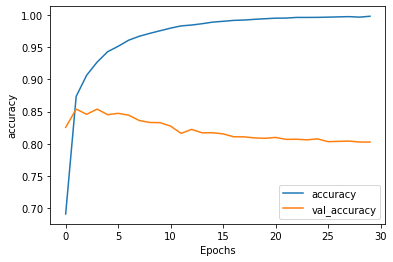

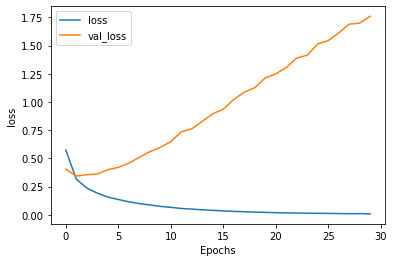

In [13]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# LSTM modeling

Apply bidirectional LSTM model on top of embedding

In [16]:
lstm_model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_sz, embedding_dim, input_length=max_length),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,)),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(1,activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 32, 16)            160000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                12544     
_________________________________________________________________
dense_8 (Dense)              (None, 24)                1560      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 25        
Total params: 174,129
Trainable params: 174,129
Non-trainable params: 0
_________________________________________________________________


In [17]:
lstm_history = lstm_model.fit(training_padded,training_labels_final,
                             epochs = num_epochs,
                             validation_data = (test_padded, test_labels_final),
                             verbose=2)

Train on 20000 samples, validate on 6709 samples
Epoch 1/30
20000/20000 - 12s - loss: 0.4280 - accuracy: 0.7817 - val_loss: 0.3291 - val_accuracy: 0.8560
Epoch 2/30
20000/20000 - 9s - loss: 0.2210 - accuracy: 0.9086 - val_loss: 0.3402 - val_accuracy: 0.8550
Epoch 3/30
20000/20000 - 9s - loss: 0.1398 - accuracy: 0.9477 - val_loss: 0.3760 - val_accuracy: 0.8520
Epoch 4/30
20000/20000 - 9s - loss: 0.0872 - accuracy: 0.9693 - val_loss: 0.5173 - val_accuracy: 0.8444
Epoch 5/30
20000/20000 - 9s - loss: 0.0542 - accuracy: 0.9824 - val_loss: 0.6194 - val_accuracy: 0.8392
Epoch 6/30
20000/20000 - 9s - loss: 0.0331 - accuracy: 0.9898 - val_loss: 0.7581 - val_accuracy: 0.8362
Epoch 7/30
20000/20000 - 9s - loss: 0.0235 - accuracy: 0.9930 - val_loss: 0.8127 - val_accuracy: 0.8380
Epoch 8/30
20000/20000 - 9s - loss: 0.0176 - accuracy: 0.9952 - val_loss: 0.9187 - val_accuracy: 0.8290
Epoch 9/30
20000/20000 - 8s - loss: 0.0128 - accuracy: 0.9960 - val_loss: 0.9493 - val_accuracy: 0.8337
Epoch 10/30
20

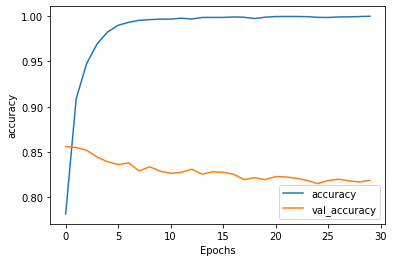

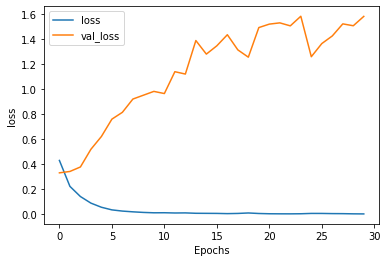

In [18]:
plot_graphs(lstm_history, "accuracy")
plot_graphs(lstm_history, "loss")

# Apply 1D Convolution filter on top of embedding

In [33]:
conv_model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_sz, embedding_dim, input_length=max_length),
        tf.keras.layers.Conv1D(128, 5, activation='relu'),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(1,activation='sigmoid')
])

conv_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
conv_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 32, 16)            160000    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 28, 128)           10368     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 24)                3096      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 25        
Total params: 173,489
Trainable params: 173,489
Non-trainable params: 0
_________________________________________________________________


In [34]:
conv_history = conv_model.fit(training_padded,training_labels_final,
                             epochs = num_epochs,
                             validation_data = (test_padded, test_labels_final),
                             verbose=2)

Train on 20000 samples, validate on 6709 samples
Epoch 1/30
20000/20000 - 3s - loss: 0.4395 - accuracy: 0.7815 - val_loss: 0.3505 - val_accuracy: 0.8520
Epoch 2/30
20000/20000 - 2s - loss: 0.2194 - accuracy: 0.9121 - val_loss: 0.3680 - val_accuracy: 0.8512
Epoch 3/30
20000/20000 - 3s - loss: 0.1011 - accuracy: 0.9642 - val_loss: 0.4794 - val_accuracy: 0.8416
Epoch 4/30
20000/20000 - 2s - loss: 0.0373 - accuracy: 0.9888 - val_loss: 0.6228 - val_accuracy: 0.8368
Epoch 5/30
20000/20000 - 2s - loss: 0.0121 - accuracy: 0.9974 - val_loss: 0.7521 - val_accuracy: 0.8427
Epoch 6/30
20000/20000 - 2s - loss: 0.0047 - accuracy: 0.9991 - val_loss: 0.8410 - val_accuracy: 0.8425
Epoch 7/30
20000/20000 - 2s - loss: 0.0026 - accuracy: 0.9992 - val_loss: 0.9174 - val_accuracy: 0.8420
Epoch 8/30
20000/20000 - 3s - loss: 0.0021 - accuracy: 0.9993 - val_loss: 0.9890 - val_accuracy: 0.8386
Epoch 9/30
20000/20000 - 3s - loss: 0.0013 - accuracy: 0.9995 - val_loss: 1.1037 - val_accuracy: 0.8377
Epoch 10/30
200

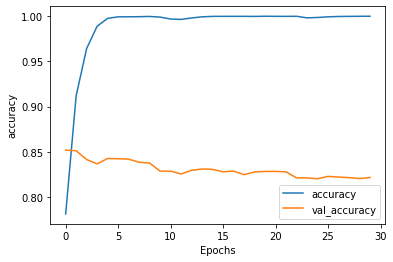

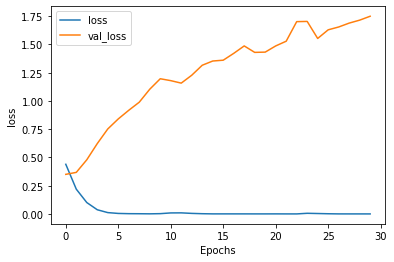

In [36]:
plot_graphs(conv_history, "accuracy")
plot_graphs(conv_history, "loss")